# PDR modelling

## Boilerplate / setup

In [1]:
import matplotlib
%matplotlib widget 
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import astropy.constants as consts
import astropy.units as units
from matplotlib.colors import LogNorm

In [3]:
font = {'size'   : 12}
matplotlib.rc('figure',figsize = (6, 5.5))
matplotlib.rc('font',**font)
plt.rcParams['figure.constrained_layout.use'] = True
# plt.rcParams.update({
#     "text.usetex": True,
#     "text.latex.preamble": "\\usepackage[lf]{ebgaramond}\\usepackage{ebgaramond-maths}",
#     #"font.family": "EBGaramond"
# })
#if you want the fancy font you have to run this cell right before you make the plot for some reason.

In [4]:
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy.plot.modelplot import ModelPlot
import pdrtpy.pdrutils as utils
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.lineratioplot import LineRatioPlot
from astropy.nddata import StdDevUncertainty
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def jy_km_s_to_lsun(jy_km_s,redshift,restwavelength):
    wm2 =jy_km_s_to_wm2_obs(jy_km_s,restwavelength*(1+redshift))
    lum = wm2 * 4 * np.pi * (cosmo.luminosity_distance(redshift))**2
    return lum.to("L_sun")

def jy_km_s_to_lsun_obs(jy_km_s,redshift,obswavelength):
#     obswavelength = obswavelength.to("km",equivalencies=units.spectral())
#     wm2 = jy_km_s * 10**-26 * units.watt/units.m**2/units.Jy/obswavelength*units.s
    wm2 = jy_km_s_to_wm2_obs(jy_km_s,obswavelength)
    lum = wm2 * 4 * np.pi * (cosmo.luminosity_distance(redshift))**2
    return lum.to("L_sun")

def jy_km_s_to_wm2_obs(jy_km_s,obswavelength):
    obswavelength = obswavelength.to("km",equivalencies=units.spectral())
    wm2 = jy_km_s * 10**-26 * units.watt/units.m**2/units.Jy/obswavelength*units.s
    return wm2

/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/pdrtpy/pdrtpy/pbar.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [5]:
import pdrtpy
pdrtpy.version()

'2.4.0a'

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=units.UnitsWarning)

## Start doing PDR modelling

### Add my measurements

In [7]:
myunit = "L_sun"
mydata = [37.7, #from alma = 8.5 x10^-19 w/m2, CII
          29,  # OI
          1.33,   
          3.81,   
          4.87,   
          4.86]*units.Jy*units.km/units.s
names =  ["CII_158",'OI_63',"CO_21","CO_43","CO_54","CO_65"]
obsfreqs = units.Quantity([(6.7201506e11 *units.Hz).to(units.GHz), 
            4744.8/(1+1.8275)*units.GHz,
            81.551*units.GHz,
            163.088*units.GHz,
            203.850*units.GHz,
            244.603*units.GHz])
uncerts = [#38, # CII line flux because we don't know corrections
            3.3, # Real CII uncertainty
           #OI line flux because we don't know geometry
           11, #Real OI uncertainty
           0.06045455, 0.48768   , 1.19315   , 0.95175]*units.Jy*units.km/units.s
# note the co uncertainties were calculated by backtracking from the relative uncertainties in the L_co in Aravena
# I_co = np.array([1.33,3.81,4.87,4.86])
# L_co = np.array([0.22,1.25,2,2.4])
# line_name = ["CO_21","CO_43","CO_54","CO_65"]
# sigma_L_co = np.array([0.01,0.16,0.49,0.47])
# sigma_I_co = sigma_L_co / L_co * I_co

m_fir = Measurement(data=7.1e12,uncertainty = StdDevUncertainty(0.3e12),identifier="FIR",unit="L_sun")

all_measurements = [m_fir]
mydata_lsun = jy_km_s_to_lsun_obs(mydata,1.8275,obsfreqs)
uncert_lsun = jy_km_s_to_lsun_obs(uncerts,1.8275,obsfreqs)
for flux,uncert,name in zip(mydata_lsun,uncert_lsun,names):
    all_measurements.append(Measurement(data=flux,
                                       uncertainty = StdDevUncertainty(uncert),
                                       identifier=name,
                                       unit=myunit))

all_meas_noco = [m_fir]
for flux,uncert,name in zip(mydata_lsun,uncert_lsun,names):
    if "CO" not in name:
        all_meas_noco.append(Measurement(data=flux,
                                       uncertainty = StdDevUncertainty(uncert),
                                       identifier=name,
                                       unit=myunit))
    
mydata_lsun[0] = mydata_lsun[0]*2 # double CII flux to better match ZEUS data
uncert_lsun[0] = jy_km_s_to_lsun_obs(10*units.Jy*units.km/units.s,1.8275,obsfreqs[0])
all_measurements_2cii = [m_fir]
for flux,uncert,name in zip(mydata_lsun,uncert_lsun,names):
    all_measurements_2cii.append(Measurement(data=flux,
                                       uncertainty = StdDevUncertainty(uncert),
                                       identifier=name,
                                       unit=myunit))
    


In [8]:
1/1940

0.0005154639175257732

In [9]:
m = all_measurements # NOTE THESE ARE UNCORRECTED! SEE ABOVE
m[1]/m[2]

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


0.5206034726005311 +/- 0.20266016727478176 

In [10]:
f"LOI={m[2]:.2e}"

'LOI=9.82e+09 +/- 3.73e+09 solLum'

In [11]:
f"LCII={m[1]:.2e}"

'LCII=5.11e+09 +/- 4.48e+08 solLum'

In [12]:
f"LFIR={m[0]:.2e}"

'LFIR=7.10e+12 +/- 3.00e+11 solLum'

In [13]:
(m[1]+m[2])/m[0]

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


0.0021033685244443274 +/- 0.0005358737127223263 

### Make the plots!

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [ast

/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/pdrtpy/pdrtpy/tool/lineratiofit.py:413: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


fitted 1 of 1 pixels
got 0 exceptions


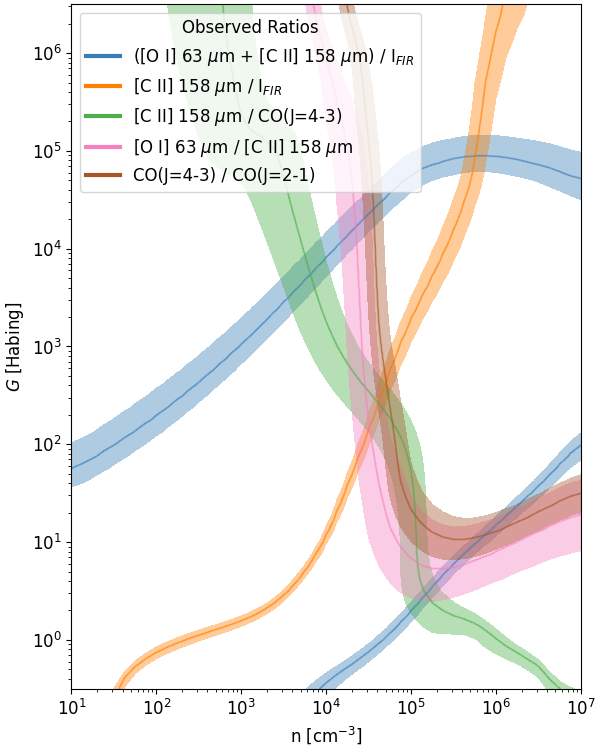

In [14]:
corrections = {
    "CII_158": 0.75,
    "OI_63": 2,
    "CO_21":1,
    "CO_43":1,
    "CO_65":1,
    "FIR":1
}
all_measurements_corrected = []
for measurement in all_measurements:
    try:
        correction_factor = corrections[measurement.id]
    except KeyError:
        correction_factor = 1
    all_measurements_corrected.append(measurement * correction_factor)
p = LineRatioFit(ModelSet("wk2020",z=1),measurements=all_measurements_corrected)
p.run()
lineplot = LineRatioPlot(p)
font = {'size'   : 12}
matplotlib.rc('figure',figsize = (6, 5.5))
matplotlib.rc('font',**font)
# plt.rcParams.update({
#     "text.usetex": True,
#     "text.latex.preamble": "\\usepackage[lf]{ebgaramond}\\usepackage{ebgaramond-maths}",
#     "font.family": "EBGaramond"
# })
omit = [
    "CII_158/CO_65",
    "CII_158/CO_21",
    "OI_63/CO_65",
    #"CII_158/CO_43",
    "OI_63/CO_21",
    "OI_63/CO_43",
    "CII_158/FIR",
    "CO_65/CO_43",
    "CO_54/CO_43",
    "CO_21/FIR",
    "CO_65/FIR",
    "OI_63/FIR"
]
lineplot.overlay_all_ratios(figsize=(6,7.5),yaxis_unit="Habing",omit=omit,loc="upper left")
plt.ylabel("$G$ [Habing]")
# plt.title("Standard corrections for OI and CII only")
plt.savefig("pdr_model_with_co.pdf")
plt.savefig("pdr_model_oifir.png")


In [15]:
plt.savefig("pdr_model_oifir.pdf")

I can try to convert $L_{FIR}$ to an estimate of $G$ remembering that $G_0 = 1.6\cdot10^{-6}$ W m$^{-2}$. I also need a ballpark source size, something like 6 by 4 kpc. Our Gaussian fit gives us 501 x 377 miliarcseconds FWHM; ellipse area is simply $\pi a b$, and FWHM is a slightly small estimate of source size. I think we decided to divide our $L_{FIR}$ by 2 to account for dust heating from sources other than FUV. I can also include my area filling factor that I calculated in my 'toy model', which is 4... I also multiplied both of the FWHMs by $\sqrt{2}$ because fwhms are usually on the smaller side. I can always change that.

In [16]:
source_size_maj=1/cosmo.arcsec_per_kpc_proper(1.8275)*.501*units.arcsec
source_size_min=1/cosmo.arcsec_per_kpc_proper(1.8275)*.377*units.arcsec
source_area = source_size_maj * source_size_min * np.pi 

In [17]:
m_fir/1e12

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


7.1 +/- 0.3 solLum

In [18]:
m_fir.convert_unit_to("W") 

2.7178800000000002e+39 +/- 1.1484e+38 W

In [19]:
(m_fir/source_area/2)

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


84049280750.41745 +/- 3551378059.876794 solLum / kpc2

In [20]:
f"{((m_fir/source_area/2)).value[0]:.2e}"

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


'8.40e+10'

In [21]:
source_area

<Quantity 42.23712527 kpc2>

In [22]:
f"{m_fir/source_area:.2e}"

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


'1.68e+11 +/- 7.10e+09 solLum / kpc2'

In [23]:
fir_wm2=(m_fir/source_area/2).convert_unit_to("W/m^2")

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


In [24]:
fir_wm2

0.03379129532822647 +/- 0.0014278012110518227 W / m2

In [25]:
g_est_fir = (m_fir/source_area/2).convert_unit_to("Habing")

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


In [26]:
(fir_wm2/g_est_fir).convert_unit_to("")

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


1.0 +/- 0.05975550263548289 

# Annotate with my lfir value converted to G0
optional, not included in paper

In [ ]:
g_est_fir.value[0] / 5e3

In [ ]:
g = g_est_fir.value[0]
ax=plt.gca()
#ax.fill_between([10,1e7],[g*0.1,g*0.1],[g*10, g*10], alpha=0.1, color="grey")
ax.plot([10,1e7],[g,g],color='k',alpha=0.3)
ax.text(3e3,
        1.2e4, 
        "$\Phi_A$", 
        ha="center", 
        va="center", 
        size=11, 
        color='k',
        rotation='vertical',
        bbox=dict(boxstyle="larrow,pad=0.3",
                  fc="lightblue", ec="steelblue", lw=2, alpha=0.7))


## Extract individual line fluxes from the models, based on $G_0$, $n$, filling factor

In [27]:
#modelset = ModelSet('wk2020',z=1) 
model_loc = utils.model_dir() + "wolfirekaufman/version2020/constant_density/z=1/"
print(model_loc)
# for i in modelset.find_files(['CII_158','CO_10']):
#     print(i)
cii_grid = Measurement.read(model_loc+'CII158sm.fits')
cii_g0_grid = Measurement.read(model_loc+'CII158G0sm.fits')
oi_grid = Measurement.read(model_loc+'OI63G0sm.fits')

/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/pdrtpy/pdrtpy/models/wolfirekaufman/version2020/constant_density/z=1/


In [28]:
from pdrtpy.plot import modelplot

In [29]:
mp = modelplot.ModelPlot(ModelSet("wk2020",z=1))

In [30]:
oi_grid.wcs.wcs.cunit

['cm-3', '']

## Export G0 grids for making the resolved G0 map

In [31]:
ms = ModelSet("wk2020",z=1)

In [32]:
mod=ms.get_model("OI_63")

In [33]:
cii=ms.get_model("CII_158")
cii.wcs.world_axis_units
oi = ms.get_model("OI_63")
oicii = ms.get_model("OI_63/CII_158")
ciifir = ms.get_model("CII_158/FIR")

In [34]:
import itertools
coords = zip(range(49),itertools.repeat(1))

In [35]:
coords = []
for i in range(57):
    coords.append(cii.wcs.pixel_to_world(24,i)[1].value)
print(cii.wcs.pixel_to_world(25,4)[1].unit)

erg / (s cm2)


In [36]:
np.save("pdrt_model_log_erg_axis_coords.npy",coords)

In [37]:
np.save("pdrt_model_cii_fir.npy",ciifir[:,24]) #Sanity check: Look up the correct location in the below two plots 
#and try to match. IDK why the indices are reversed...

In [38]:
cii.wcs.world_to_array_index(4*units.cm**-3,0*units.erg/units.cm**2/units.s)[1]

24

In [39]:
cii.wcs.world_to_array_index(4*units.cm**-3,0*units.erg/units.cm**2/units.s)[1]

24

In [40]:
cii.wcs.world_to_array_index(3.5*units.cm**-3,0*units.erg/units.cm**2/units.s)[1]

20

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


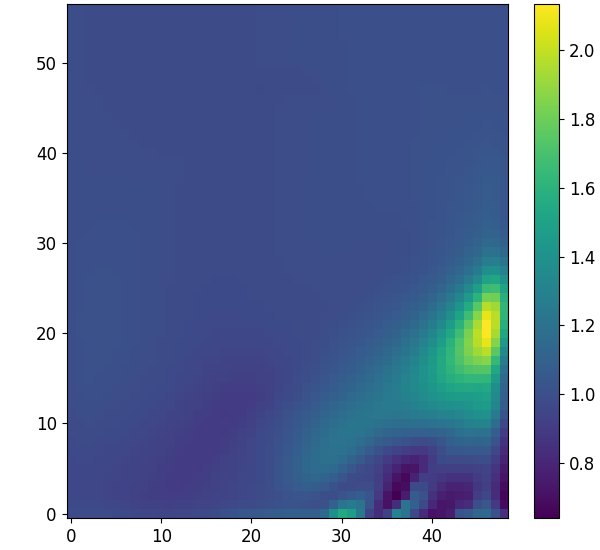

In [41]:
plt.figure()
plt.imshow((oicii/(oi/cii)),origin="lower")
plt.colorbar()